In [7]:
import numpy as np
import pandas as pd

import torch 
from torch import nn
from torch.utils import data

from d2l import torch as d2l

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 读取和处理数据集

In [9]:
# 读取数据集
sample_submission = pd.read_csv('./dataset/sample_submission.csv')
train_data = pd.read_csv('./dataset/train.csv')
test_data = pd.read_csv('./dataset/test.csv')

# 数据集形状
sample_submission.shape, train_data.shape, test_data.shape

((31626, 2), (47439, 41), (31626, 40))

In [10]:
# 查看前 5 行样本
train_data.head()

,Id,Address,Sold Price,Summary,Type,Year built,Heating,Cooling,Parking,Lot,...,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,0,540 Pine Ln,3825000.0,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,1969.0,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan","Garage, Garage - Attached, Covered",1.0,...,"Garage, Garage - Attached, Covered",886486.0,12580.0,2019-10-24,4198000.0,NaN,NaN,Los Altos,94022,CA
1,1,1727 W 67th St,505000.0,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,1926.0,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...","Detached Carport, Garage",4047.0,...,"Detached Carport, Garage",505000.0,6253.0,2019-10-16,525000.0,2019-08-30,328000.0,Los Angeles,90047,CA
2,2,28093 Pine Ave,140000.0,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,1958.0,Forced air,NaN,0 spaces,9147.0,...,NaN,49627.0,468.0,2019-08-25,180000.0,NaN,NaN,Strawberry,95375,CA
3,3,10750 Braddock Dr,1775000.0,Rare 2-story Gated 5 bedroom Modern Mediterran...,SingleFamily,1947.0,Central,Central Air,"Detached Carport, Driveway, Garage - Two Door",NaN,...,"Detached Carport, Driveway, Garage - Two Door",1775000.0,20787.0,2019-10-24,1895000.0,2016-08-30,1500000.0,Culver City,90230,CA
4,4,7415 O Donovan Rd,1175000.0,Beautiful 200 acre ranch land with several pas...,VacantLand,NaN,NaN,NaN,0 spaces,NaN,...,NaN,NaN,NaN,2019-06-07,1595000.0,2016-06-27,900000.0,Creston,93432,CA


In [11]:
# 训练集概览
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47439 entries, 0 to 47438
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           47439 non-null  int64  
 1   Address                      47439 non-null  object 
 2   Sold Price                   47439 non-null  float64
 3   Summary                      47085 non-null  object 
 4   Type                         47439 non-null  object 
 5   Year built                   46394 non-null  float64
 6   Heating                      40587 non-null  object 
 7   Cooling                      26745 non-null  object 
 8   Parking                      46065 non-null  object 
 9   Lot                          33258 non-null  float64
 10  Bedrooms                     44567 non-null  object 
 11  Bathrooms                    43974 non-null  float64
 12  Full bathrooms               39574 non-null  float64
 13  Total interior l

In [12]:
# 连接训练集和测试集特征
all_features = pd.concat((train_data.loc[:, train_data.columns != 'Sold Price'], test_data.iloc[:, 1:]))
all_features = all_features.drop(['Id', 'State', 'Summary', 'Address'], axis=1)
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79065 entries, 0 to 31625
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Type                         79065 non-null  object 
 1   Year built                   77123 non-null  float64
 2   Heating                      66858 non-null  object 
 3   Cooling                      48921 non-null  object 
 4   Parking                      76740 non-null  object 
 5   Lot                          56076 non-null  float64
 6   Bedrooms                     74467 non-null  object 
 7   Bathrooms                    73655 non-null  float64
 8   Full bathrooms               66137 non-null  float64
 9   Total interior livable area  75187 non-null  float64
 10  Total spaces                 77398 non-null  float64
 11  Garage spaces                77398 non-null  float64
 12  Region                       79063 non-null  object 
 13  Elementary School    

In [13]:
# 预处理

# 提取数值类特征的索引
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# 数值特征标准化
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

# 填充均值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# 转换为标准日期格式
all_features['Listed On'] = pd.to_datetime(all_features['Listed On'], format="%Y-%m-%d")
all_features['Last Sold On'] = pd.to_datetime(all_features['Last Sold On'], format="%Y-%m-%d")

# 截取出数值特征，和类别数较少的特征`Type`
features = list(numeric_features)
features.append('Type')
all_features = all_features[features]

# 对特征`Type`进行独热编码（Nan值也作为一列特征进行编码）
all_features = pd.get_dummies(all_features, dummy_na=True)

# 确保所有数据类型都为float32或int类型
all_features = all_features.astype('float32')

# 预览前5个样本
all_features.head()

,Year built,Lot,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,...,"Type_Townhouse, Low-Rise (1-3)",Type_Triplex,"Type_Unit Below, 2 Level, Detached","Type_Unit Below, Flat, Unit Above","Type_Unit Below, Low-Rise (1-3), Full","Type_Unit Below, Low-Rise (1-3), Full, Unit Above, Attached",Type_Unknown,Type_Vacant Land,Type_VacantLand,Type_nan
0,0.048505,-0.018489,-2.058002,0.000000,-0.006552,-0.135519,-0.123623,0.622758,-0.339282,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.284656,-0.018287,-0.336769,-0.106424,-0.005198,-0.062731,-0.050507,-1.308481,-0.156142,-1.607235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.036722,-0.018031,0.523848,-1.167570,-0.004763,-0.135519,-0.123623,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.121949,0.000000,0.523848,0.954722,-0.002493,-0.135519,-0.123623,1.588378,-0.430851,0.865487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.139948,3.369292,-0.123602,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
# 转换为张量格式
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data['Sold Price'].values.reshape(-1, 1), dtype=torch.float32)

in_features = train_features.shape[1] # 输入特征数

# 模型和损失函数

In [15]:
# 损失函数
loss = nn.MSELoss()

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))  # 为了在取对数时稳定数值，将小于1的值设置为1
    rmse = torch.sqrt(loss(
        torch.log(clipped_preds),
        torch.log(labels)
    ))
    return rmse

In [16]:
# 模型
def get_net():
    net = nn.Sequential(
        nn.Linear(in_features, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    )
    return net

# 训练

In [17]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [18]:
def train(net, 
          train_features, train_labels, test_features, test_labels,
          num_epochs, lr, weight_decay, batch_size):
    """训练过程"""
    train_ls, test_ls = [], []
    train_iter = load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=lr, weight_decay=weight_decay)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:

            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            l = loss(net(X), y).to(device)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    
    return train_ls, test_ls


In [19]:
# k折交叉验证输入
def get_k_fold_data(k, i, X, y):

    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None

    for j in range(k):
        idx = slice(j * fold_size, (j + 1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]

        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    
    return X_train, y_train, X_valid, y_valid

# k折交叉验证
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net().to(device)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log') 
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

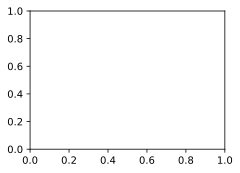

In [20]:
train_features=train_features.to(device)
train_labels=train_labels.to(device)
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 0.1, 256
train_l, valid_l, model= k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

# 预测

In [ ]:
# 模型预测方法
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net().to(device)
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().cpu().numpy()
    return preds

In [ ]:
test_features = test_features.to(device)
train_features = train_features.to(device)
train_labels = train_labels.to(device)
preds = train_and_pred(train_features, test_features, train_labels, test_data,
                       num_epochs, lr, weight_decay, batch_size) 